In [2]:
#Packages
import warnings
warnings.filterwarnings('ignore')

import glob
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from PIL import Image

from pymks import (plot_microstructures, PrimitiveTransformer, TwoPointCorrelation)

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
#Append images to lists.

path_train=r"C:\Users\mikep\Desktop\project\data\final\binarized\training"
path_test=r"C:\Users\mikep\Desktop\project\data\final\binarized\testing"

images_train = []
images_test = []

def number(filename):
    return int(filename[61:-4])

def number2(filename):
    return int(filename[60:-4])

for filename in sorted(glob.glob(path_train+"\*.tif"),
                       key=number):
    im=Image.open(filename)
    images_train.append(im)

for filename_b in sorted(glob.glob(path_test+"\*.tif"),
                       key=number2):
    im_b=Image.open(filename_b)
    images_test.append(im_b)

In [5]:
#List comprehension to convert the members of the "images" lists to arrays.
imarrays_tr = [np.array(x) for x in images_train]
imarrays_te = [np.array(x1) for x1 in images_test]
imarrays_te[0].shape

(600, 600)

In [6]:
#Stacking all image arrays to create the 'sample' dimension and to convert the list to an array.
data_a_tr = np.stack(imarrays_tr, axis=0)
data_a_te = np.stack(imarrays_te, axis=0)
data_a_te.shape

(10, 600, 600)

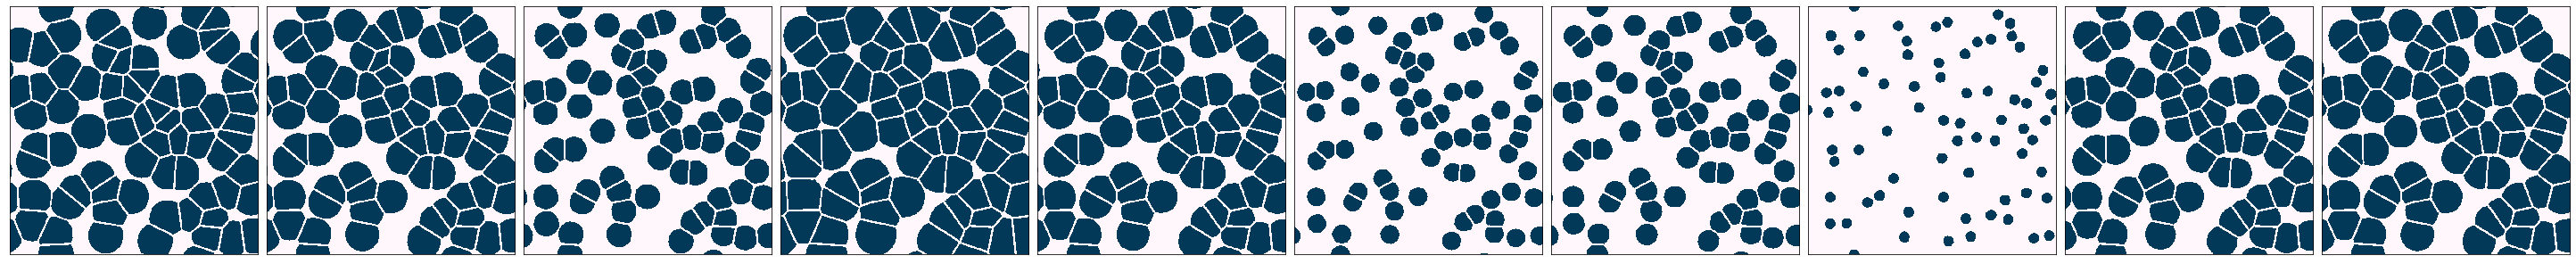

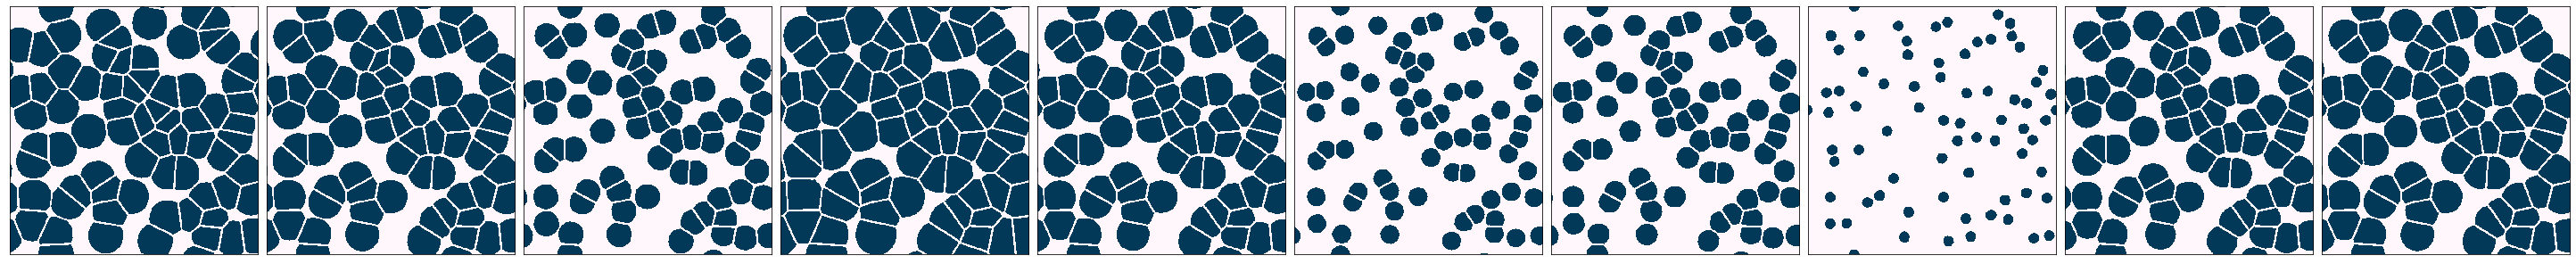

In [7]:
#Visualization of the first 10 training microstructures.
plot_microstructures(*data_a_tr[0:10], cmap='PuBu', colorbar=False)

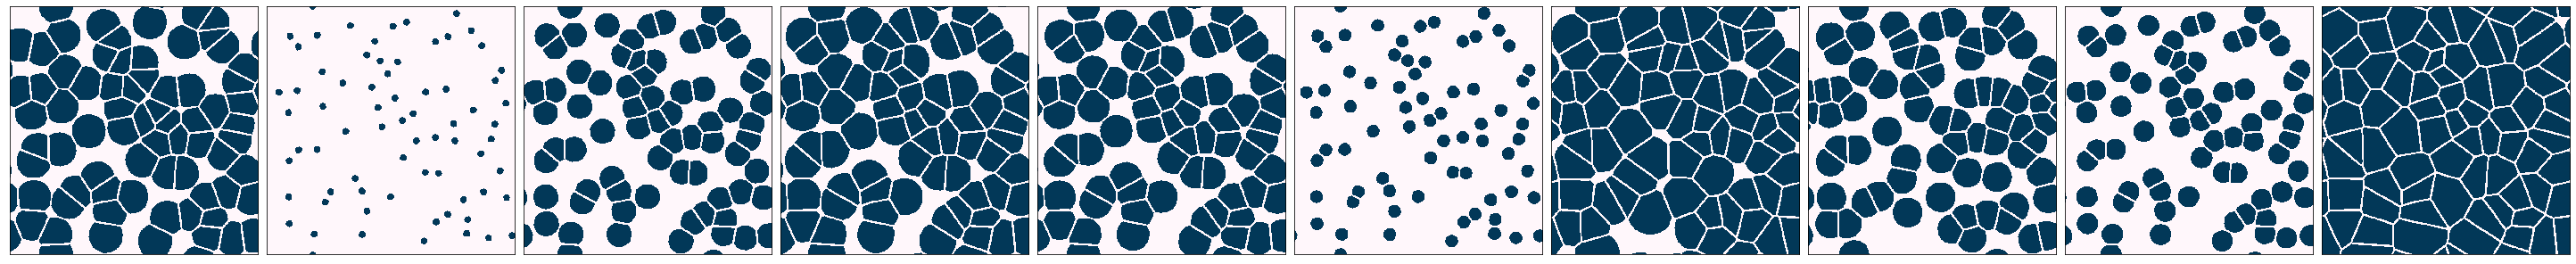

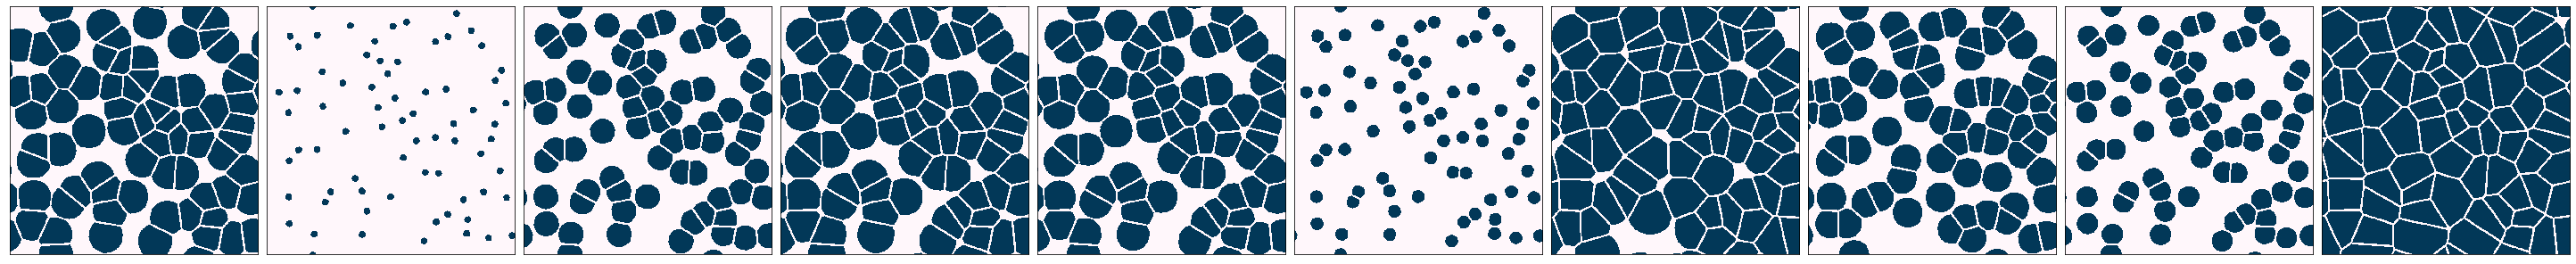

In [8]:
#Visualization of the testing microstructures.
plot_microstructures(*data_a_te[0:10], cmap='PuBu', colorbar=False)

In [9]:
#List comprehension to add the "phases" axis with the PrimitiveTransformer class.
data_tr = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(data_a_tr)
data_te = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(data_a_te)
data_tr.shape

(24, 600, 600, 2)

In [10]:
#Swaping the columns to solve the evolution issue.
data_tr[:, :, :, [0, 1]]= data_tr[:, :, :, [1, 0]]
data_te[:, :, :, [0, 1]]= data_te[:, :, :, [1, 0]]

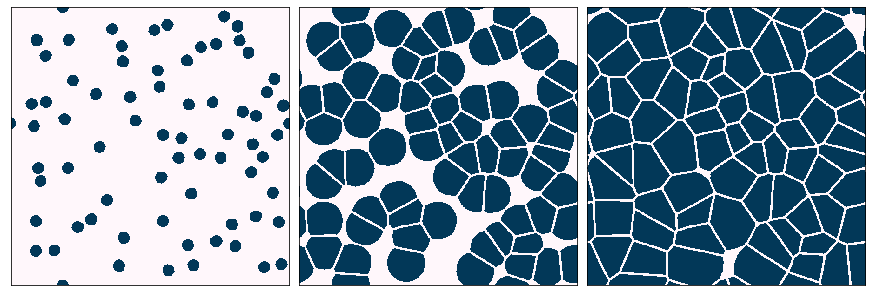

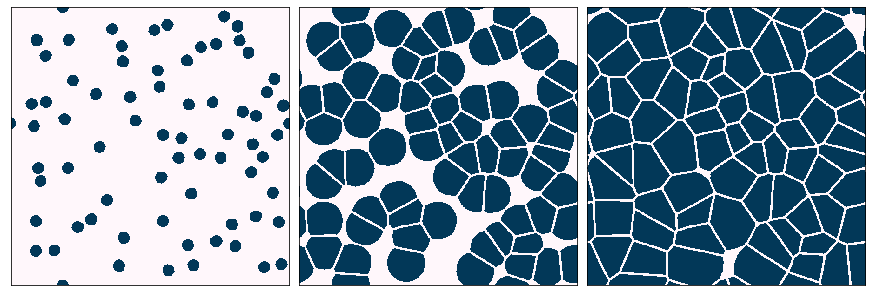

In [11]:
#Plotting three microstructures.
plot_microstructures(data_tr[7, :, :, 0], data_tr[1, :, :, 0], data_tr[11, :, :, 0], cmap='PuBu', colorbar=False)

In [17]:
#Calculating two-point statistics.
two_points_tr = TwoPointCorrelation(periodic_boundary=True, cutoff=30, correlations=[(0, 0), (0, 1)]).transform(data_tr)
two_points_te = TwoPointCorrelation(periodic_boundary=True, cutoff=130, correlations=[(0, 0), (0, 1)]).transform(data_te)

In [13]:
initial_shape_tr = two_points_tr.shape
initial_shape_te = two_points_te.shape

initial_shape_tr

(24, 261, 261, 2)

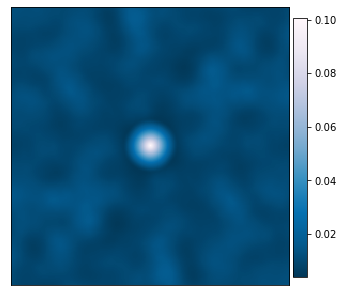

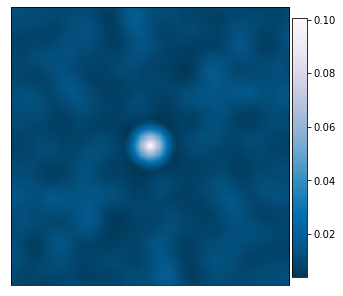

In [13]:
#Plotting two-point statistics.
plot_microstructures(two_points_tr[7, :, :, 0], cmap='PuBu_r', colorbar=True, showticks=False)

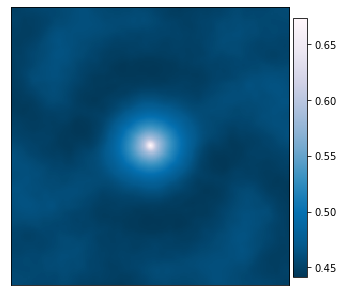

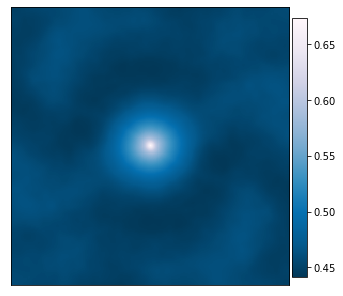

In [14]:
plot_microstructures(two_points_tr[1, :, :, 0], cmap='PuBu_r', colorbar=True, showticks=False)

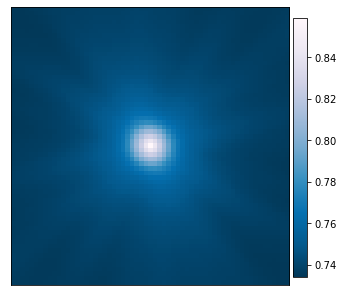

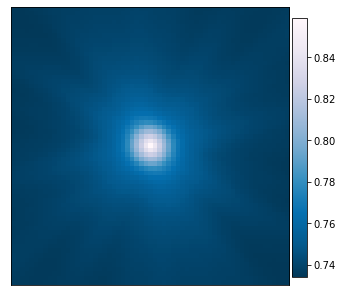

In [18]:
plot_microstructures(two_points_tr[11, :, :, 0], cmap='PuBu_r', colorbar=True, showticks=False)

In [17]:
#Recrystallized Volume Fraction
print('Recrystallized Volume Fraction 7 = ', two_points_tr[7, 130, 130, 0].compute())
print('Recrystallized Volume Fraction 1 = ', two_points_tr[1, 130, 130, 0].compute())
print('Recrystallized Volume Fraction 11 = ', two_points_tr[11, 130, 130, 0].compute())

Recrystallized Volume Fraction 7 =  0.10049444444444444
Recrystallized Volume Fraction 1 =  0.6735861111111112
Recrystallized Volume Fraction 11 =  0.8588722222222223


In [18]:
#Reshape the two-point statistics for the PCA model.
reshaped_two_points_tr = two_points_tr.reshape(24, -1)
reshaped_two_points_te = two_points_te.reshape(10, -1)

reshaped_two_points_tr.shape, reshaped_two_points_te.shape

((24, 136242), (10, 136242))

In [19]:
#PCA
pca = PCA(svd_solver='full', n_components=3)

pc_scores_tr = pca.fit_transform(reshaped_two_points_tr)
pc_scores_te = pca.transform(reshaped_two_points_te)

pc_scores_tr.shape, pc_scores_te.shape
print(pc_scores_tr)

[[ 3.51439301e+01 -5.81730570e+00  1.77942246e-01]
 [ 2.41125829e+01 -8.75478198e+00 -6.55963077e-01]
 [-3.67425174e+01 -1.57751775e+01  5.24524519e-01]
 [ 6.66920880e+01  4.18185882e+00  7.93397039e-02]
 [ 1.77315712e+01 -1.02806963e+01 -6.63677046e-01]
 [-7.19562319e+01 -4.49851892e+00  1.42923963e+00]
 [-5.73471091e+01 -1.17752548e+01  1.22943395e+00]
 [-9.19498572e+01  2.62524925e+01 -1.00536745e+00]
 [ 7.20021364e-01 -1.36191886e+01 -4.80975353e-01]
 [ 2.15015548e+01 -9.39550296e+00 -6.61999817e-01]
 [-3.86148511e+01 -1.56189952e+01  5.83431088e-01]
 [ 9.78001309e+01  1.59339294e+01  6.52901671e-01]
 [-8.18592255e+01  4.84373635e+00  1.03563505e+00]
 [ 4.71233669e+01 -2.37863285e+00 -4.62840382e-01]
 [-2.45377008e+01 -1.60981108e+01  1.21216038e-01]
 [ 7.78037212e+01  8.20561898e+00  3.46090409e-01]
 [ 2.15816693e+01 -9.48838702e+00 -1.09139131e+00]
 [-8.63310356e+01  1.14308698e+01 -2.26945512e-01]
 [-9.03178750e+01  2.09156337e+01 -7.10689362e-01]
 [ 1.00486123e+02  1.70279406e+

In [20]:
print(pca.components_)
print(pca.components_.shape)

[[ 3.80253093e-03 -1.59638117e-05  3.80256226e-03 ... -1.59951370e-05
   3.80253093e-03 -1.59638117e-05]
 [ 1.00936875e-04 -3.90363816e-03  1.10943486e-04 ... -3.91364477e-03
   1.00936875e-04 -3.90363816e-03]
 [ 3.15849258e-03 -2.93950363e-03  3.22136603e-03 ... -3.00237708e-03
   3.15849258e-03 -2.93950363e-03]]
(3, 136242)


In [21]:
#First principal component (PC1). 
pc1_tr, pc2_tr, pc3_tr = np.split(pc_scores_tr, 3, axis=1)
pc1_te, pc2_te, pc3_te = np.split(pc_scores_te, 3, axis=1)

print(pc1_tr.shape, pc1_te.shape)
print(pc1_te)

##Note: No "axis=1" in order to obtain pc-scores for different microstructure classes.

(24, 1) (10, 1)
[[ 27.58528698]
 [-94.02168252]
 [-37.3709383 ]
 [ 44.96159883]
 [ 16.84209892]
 [-89.15055373]
 [ 78.21496067]
 [ -6.77301829]
 [-59.9976976 ]
 [101.77028135]]


In [22]:
zeros_tr=np.zeros((24, 2))
zeros_te=np.zeros((10, 2))

reshaped_pc1_tr=np.hstack((pc1_tr, zeros_tr))
reshaped_pc1_te=np.hstack((pc1_te, zeros_te))

print(reshaped_pc1_tr.shape, reshaped_pc1_te.shape)
print(reshaped_pc1_te)

(24, 3) (10, 3)
[[ 27.58528698   0.           0.        ]
 [-94.02168252   0.           0.        ]
 [-37.3709383    0.           0.        ]
 [ 44.96159883   0.           0.        ]
 [ 16.84209892   0.           0.        ]
 [-89.15055373   0.           0.        ]
 [ 78.21496067   0.           0.        ]
 [ -6.77301829   0.           0.        ]
 [-59.9976976    0.           0.        ]
 [101.77028135   0.           0.        ]]


In [23]:
#Explained variance by each principal component.
exp_var_pca=pca.explained_variance_ratio_*100
cum_sum=np.cumsum(pca.explained_variance_ratio_)*100
cum_sum_2d = [ '%.2f' % elem for elem in cum_sum ]
cum_sum_2d = np.array(cum_sum_2d)

print(exp_var_pca)

[9.60394448e+01 3.92543879e+00 1.20534502e-02]


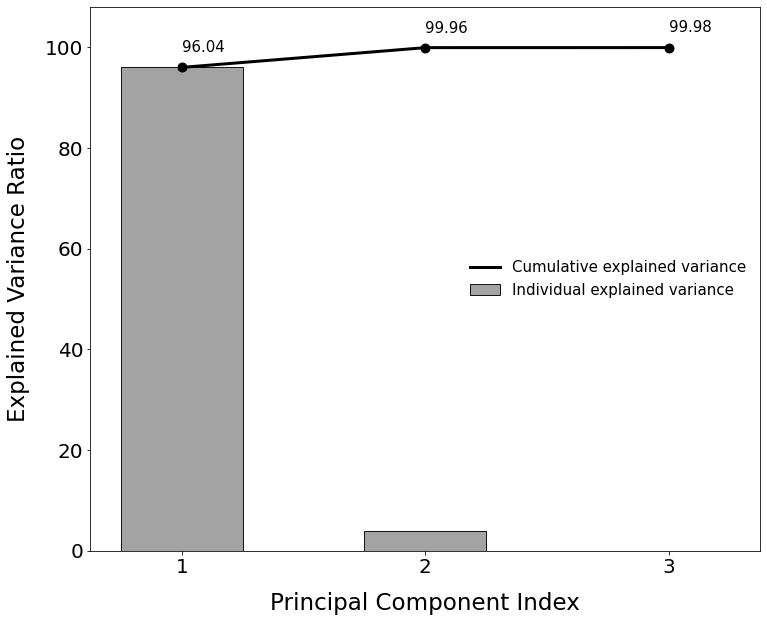

In [24]:
#plot explained variance

plt.rcParams.update({'font.size': 15})

fig = plt.figure(1, figsize=(12, 10))

x1 = range(1, len(exp_var_pca)+1)
y1 = exp_var_pca
x2 = range(1, len(cum_sum)+1)
y2 = cum_sum

plt.bar(x1, y1, color='#999999', edgecolor='black', linewidth='1', alpha=0.9, width = 0.5, align='center', label='Individual explained variance')

plt.plot(x2, y2, label='Cumulative explained variance', c='black', linewidth=3)
plt.scatter(x2, y2, s=80, facecolors='black', edgecolors='black')

for i, txt in enumerate(cum_sum_2d):
    plt.annotate(txt, (x2[i], y2[i]), size=15, xytext=(x2[i], y2[i]+3))
    
plt.xlabel('Principal Component Index', fontsize=23, labelpad=15)
plt.ylabel('Explained Variance Ratio', fontsize=23, labelpad=15)

plt.xticks(np.arange(1, 4, step=1), fontsize=20)
plt.yticks(fontsize=20)

plt.legend(frameon=False, loc='best')
plt.ylim([0, 108])

#fig.savefig(r'C:\Users\mikep\Desktop\thesis\figures\explained_variance.png', facecolor='w', dpi=600)
plt.show()

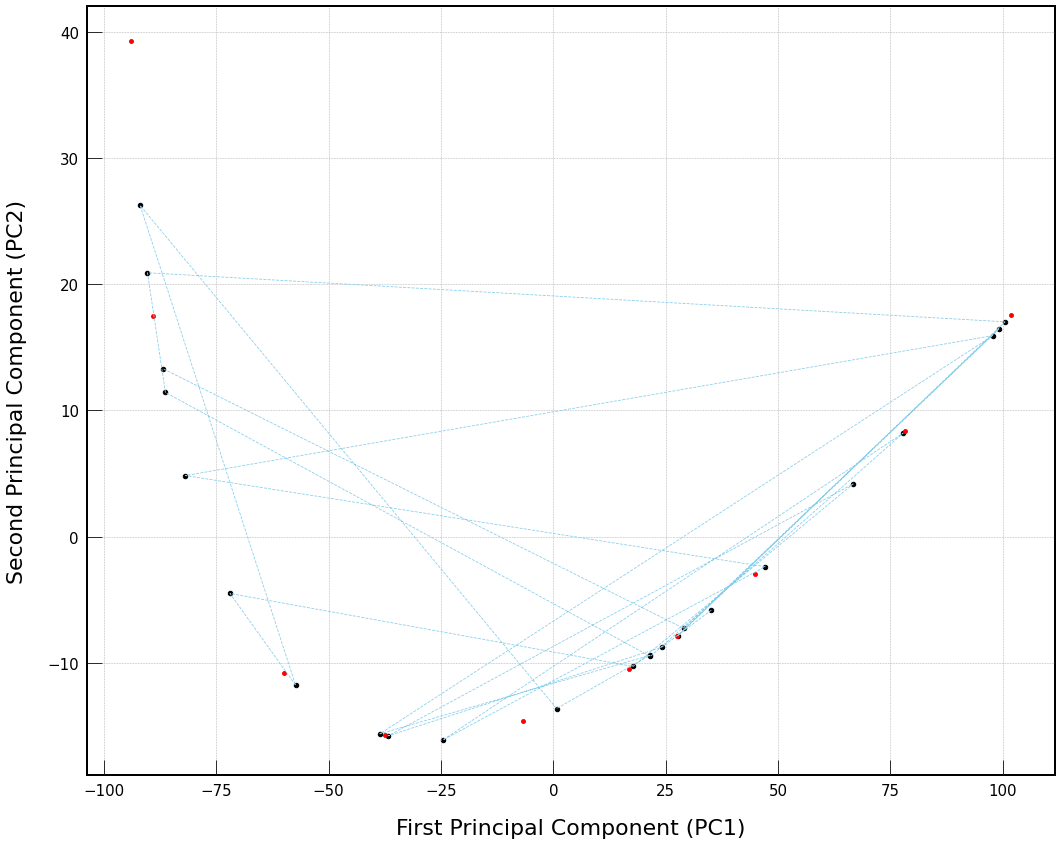

In [25]:
#Principal component analysis visualization.

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111)

plt.scatter(pc_scores_tr[:,0], pc_scores_tr[:,1], c='black', marker='o', s=20, label='Y_train') # markeredgecolor='black') 
plt.plot(pc_scores_tr[:,0], pc_scores_tr[:,1], c='skyblue', ls='--', linewidth=0.8)

plt.scatter(pc_scores_te[:,0], pc_scores_te[:,1], c='red', marker='o', s=15, label='Y_test') # markeredgecolor='black') 
#plt.plot(pc_scores_te[:,0], pc_scores_te[:,1], c='black', ls='--', linewidth=0.8)

ax.set_xlabel("First Principal Component (PC1)",  fontsize=22, labelpad=20)
ax.set_ylabel("Second Principal Component (PC2)",  fontsize=22, labelpad=20)

ax.tick_params(axis="both", size=15, direction="in", pad=8)

#ax.set_title('Time Evolution of PC-scores', fontsize=30, pad=20)

ax.grid(which='major', axis='both', linestyle = '--', linewidth = 0.5)

ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('2') 

#n = range(0,20)
#for i, txt in enumerate(n):
    #plt.annotate(txt, (pc_scores_tr[i,0], pc_scores_tr[i,1]), xytext=(pc_scores_tr[i,0]+1, pc_scores_tr[i,1]), size=10)

fig.tight_layout()
fig.savefig(r'C:\Users\mikep\Desktop\thesis\figures\pc-evolution_b2.png', facecolor='w', dpi=600)
fig.show()

In [26]:
#Inverting the data.
two_points_inv_pc_tr = pca.inverse_transform(pc_scores_tr)
two_points_inv_pc1_tr = pca.inverse_transform(reshaped_pc1_tr)

two_points_inv_pc_te = pca.inverse_transform(pc_scores_te)
two_points_inv_pc1_te = pca.inverse_transform(reshaped_pc1_te)

In [27]:
#Reshaping the data.
recovered_two_points_pc_tr = np.reshape(two_points_inv_pc_tr, initial_shape_tr)
recovered_two_points_pc1_tr = np.reshape(two_points_inv_pc1_tr, initial_shape_tr)

recovered_two_points_pc_te = np.reshape(two_points_inv_pc_te, initial_shape_te)
recovered_two_points_pc1_te = np.reshape(two_points_inv_pc1_te, initial_shape_te)

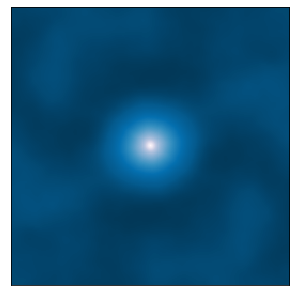

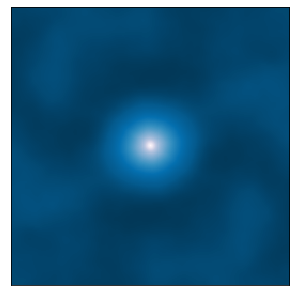

In [28]:
#Recovered two-point statistics using both PC scores.
plot_microstructures(recovered_two_points_pc_tr[1, :, :, 0], cmap='PuBu_r', colorbar=False, showticks=False)

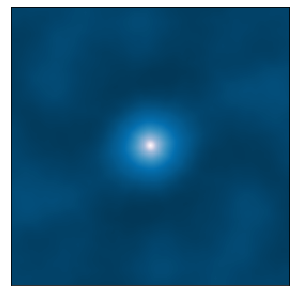

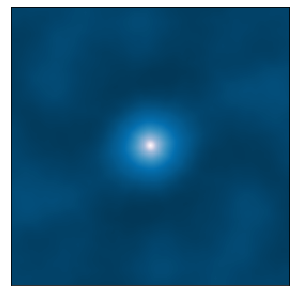

In [29]:
#Recovered first two-point statistics using only PC1.
plot_microstructures(recovered_two_points_pc1_tr[1, :, :, 0], cmap='PuBu_r', colorbar=False, showticks=False)

In [33]:
#Saving the pc scores.
df_pc1_tr = pd.DataFrame(pc1_tr)
df_pc1_te = pd.DataFrame(pc1_te)

df_pc_tr = pd.DataFrame(pc_scores_tr)
df_pc_te = pd.DataFrame(pc_scores_te)

df_pc1_tr.to_csv(r'C:\Users\mikep\Desktop\project\data\final\pc1_tr.csv')
df_pc1_te.to_csv(r'C:\Users\mikep\Desktop\project\data\final\pc1_te.csv')

df_pc_tr.to_csv(r'C:\Users\mikep\Desktop\project\data\final\pc_scores_tr.csv')
df_pc_te.to_csv(r'C:\Users\mikep\Desktop\project\data\final\pc_scores_te.csv')

In [32]:
df_pc_te

,0,1,2
0,27.585287,-7.837363,0.155106
1,-94.021683,39.267344,-1.676609
2,-37.370938,-15.726415,0.539717
3,44.961599,-2.958826,-0.365137
4,16.842099,-10.480194,-0.657761
5,-89.150554,17.485753,0.031874
6,78.214961,8.376480,-0.063127
7,-6.773018,-14.605133,-0.660341
8,-59.997698,-10.822060,1.302247
9,101.770281,17.556676,0.665783


In [34]:
zeros2_tr=np.zeros((24, 3))
zeros2_tr[(1,0)]=2.41125829e+01
print(zeros2_tr)

[[ 0.         0.         0.       ]
 [24.1125829  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.       ]]


In [35]:
two_points_inv_pcnew_tr = pca.inverse_transform(zeros2_tr)
print(two_points_inv_pcnew_tr.shape)

(24, 136242)


In [36]:
recovered_two_points_tr = np.reshape(two_points_inv_pcnew_tr, initial_shape_tr)
print(recovered_two_points_tr.shape)

(24, 261, 261, 2)


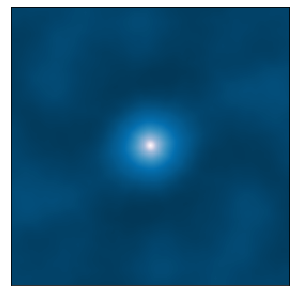

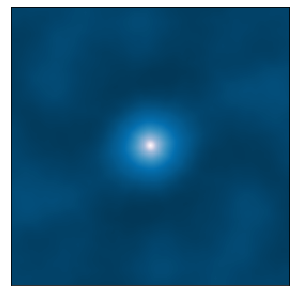

In [38]:
plot_microstructures(recovered_two_points_tr[1, :, :, 0], colorbar=False, cmap='PuBu_r', showticks=False)